In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora/sample_submission.csv
/kaggle/input/quora/train.csv
/kaggle/input/quora/test.csv


In [2]:
!pip install gensim
!pip install emot
!pip install emojis
!pip install pandarallel

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Created wheel for pandarallel: filename=pandarallel-1.5.1-py3-none-any.whl size=17127 sha256=0de5def8164fdf0befa9bb09abc47d34bf67a4606e992937b2e98245c430c5ec
  Stored in directory: /root/.cache/pip/wheels/bd/da/5f/2e65e230a994adb965df002373975e66b3bd1cb90c0706b9ac
Successfully built pandarallel
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import os
import json
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

import nltk
import operator 
import re
import gc
import keras
import gensim

from nltk import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from tqdm import tqdm
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# Loading the training data

qiq_trn = pd.read_csv("/kaggle/input/quora/train.csv")
print("Number of texts: ", qiq_trn.shape[0])

Number of texts:  783673


In [5]:
# Loading the test data

qiq_tst = pd.read_csv("/kaggle/input/quora/test.csv")
print("Number of texts: ", qiq_tst.shape[0])

Number of texts:  522449


# Text processing - TRAINING DATASET

In [6]:
df_trn = pd.DataFrame(qiq_trn["qid"])

In [7]:
# lowercasing the words

def lowerCase(text):
    lower_case = text.lower()
    return lower_case

df_trn["lowercase"] = qiq_trn["question_text"].apply(lambda text: lowerCase(text))

In [8]:
# Removing html tags

def rmvHtmlTags(text):
    html_pattern = r'<.*?>'
    no_html = re.sub(pattern=html_pattern, repl=' ', string=text)
    return no_html

df_trn["nohtmltags"] = df_trn["lowercase"].apply(lambda text: rmvHtmlTags(text)) 

In [9]:
def rmvUrls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    nourl = re.sub(pattern=url_pattern, repl=' ', string=text)
    return nourl

df_trn["nourls"] = df_trn["nohtmltags"].apply(lambda text: rmvUrls(text))


In [10]:
!pip install contractions

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [11]:
# Removing numbers

def rmvNums (text):
    num_pattern = r'\d+'
    no_num = re.sub(pattern=num_pattern, repl = ' ', string=text)
    return no_num
    
df_trn["nonumbers"] = df_trn["nourls"].apply(lambda text: rmvNums(text))  




In [12]:
# Expand contractions

import contractions

df_trn['nocontraction'] = df_trn['nonumbers'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df_trn['nocontract'] = df_trn['nocontraction'].apply(lambda x: " ".join(x))



In [13]:
# Removing of Punctuations or Special Characters

from string import punctuation

def rmvPunctuation(text):
    no_punct = text.translate(str.maketrans('', '', punctuation))
    return no_punct

df_trn["nopunct"] = df_trn["nocontract"].apply(lambda text: rmvPunctuation(text)) 

In [14]:
# Removing special characters

def rmvSplChars(text):
    alphanumeric = [character for character in text if character.isalnum()]
    text = "".join(alphanumeric)
    return text

df_trn["no_splchars"] = df_trn["nopunct"].apply(lambda text: rmvPunctuation(text))

In [15]:
df_trn.head(5)

,qid,lowercase,nohtmltags,nourls,nonumbers,nocontraction,nocontract,nopunct,no_splchars
0,6f47b0f60633c2056455,"how can i reply to this comment, ""india is poo...","how can i reply to this comment, ""india is poo...","how can i reply to this comment, ""india is poo...","how can i reply to this comment, ""india is poo...","[how, can, i, reply, to, this, comment,, ""indi...","how can i reply to this comment, ""india is poo...",how can i reply to this comment india is poor ...,how can i reply to this comment india is poor ...
1,d49b3966070b27bf07fc,what did they use for transportation in ancien...,what did they use for transportation in ancien...,what did they use for transportation in ancien...,what did they use for transportation in ancien...,"[what, did, they, use, for, transportation, in...",what did they use for transportation in ancien...,what did they use for transportation in ancien...,what did they use for transportation in ancien...
2,6d5faa49380557c8ca7b,what are the most important provisions of obam...,what are the most important provisions of obam...,what are the most important provisions of obam...,what are the most important provisions of obam...,"[what, are, the, most, important, provisions, ...",what are the most important provisions of obam...,what are the most important provisions of obam...,what are the most important provisions of obam...
3,cebea75faa47388edcf5,at what age do most finns master english today?,at what age do most finns master english today?,at what age do most finns master english today?,at what age do most finns master english today?,"[at, what, age, do, most, finns, master, engli...",at what age do most finns master english today?,at what age do most finns master english today,at what age do most finns master english today
4,2a7b76a679cadb0a016e,what is cheapest place to live in india for on...,what is cheapest place to live in india for on...,what is cheapest place to live in india for on...,what is cheapest place to live in india for on...,"[what, is, cheapest, place, to, live, in, indi...",what is cheapest place to live in india for on...,what is cheapest place to live in india for on...,what is cheapest place to live in india for on...


In [16]:
# Convert accented characters to ASCII characters

import unidecode

def accented_to_ascii(text):
    text = unidecode.unidecode(text)
    return text

df_trn["noaccented"] = df_trn["no_splchars"].apply(lambda text: accented_to_ascii(text)) 

In [17]:
# Removing single characters

def rmvSincgleChars (text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

df_trn["nosinglechars"] = df_trn["noaccented"].apply(lambda text: rmvSincgleChars(text)) 

In [18]:
# Implementation  of removing extra whitespaces

def rmvExtraSpaces(text):
    space_pattern = r'\s+'
    without_space = re.sub(pattern=space_pattern, repl=" ", string=text)
    return without_space

df_trn["nospaces"] = df_trn["nosinglechars"].apply(lambda text: rmvExtraSpaces(text)) 

In [19]:
# Removing stop words
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

STOPWORDS = set(stopwords.words('english'))
def rmvStopwords(text):
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    return text

df_trn["nostopwords"] = df_trn["nospaces"].apply(lambda text: rmvStopwords(text)) 

In [20]:
df_trn.head(5)

,qid,lowercase,nohtmltags,nourls,nonumbers,nocontraction,nocontract,nopunct,no_splchars,noaccented,nosinglechars,nospaces,nostopwords
0,6f47b0f60633c2056455,"how can i reply to this comment, ""india is poo...","how can i reply to this comment, ""india is poo...","how can i reply to this comment, ""india is poo...","how can i reply to this comment, ""india is poo...","[how, can, i, reply, to, this, comment,, ""indi...","how can i reply to this comment, ""india is poo...",how can i reply to this comment india is poor ...,how can i reply to this comment india is poor ...,how can i reply to this comment india is poor ...,how can reply to this comment india is poor it...,how can reply to this comment india is poor it...,reply comment india poor fact understand unnec...
1,d49b3966070b27bf07fc,what did they use for transportation in ancien...,what did they use for transportation in ancien...,what did they use for transportation in ancien...,what did they use for transportation in ancien...,"[what, did, they, use, for, transportation, in...",what did they use for transportation in ancien...,what did they use for transportation in ancien...,what did they use for transportation in ancien...,what did they use for transportation in ancien...,what did they use for transportation in ancien...,what did they use for transportation in ancien...,use transportation ancient india
2,6d5faa49380557c8ca7b,what are the most important provisions of obam...,what are the most important provisions of obam...,what are the most important provisions of obam...,what are the most important provisions of obam...,"[what, are, the, most, important, provisions, ...",what are the most important provisions of obam...,what are the most important provisions of obam...,what are the most important provisions of obam...,what are the most important provisions of obam...,what are the most important provisions of obam...,what are the most important provisions of obam...,important provisions obamacare
3,cebea75faa47388edcf5,at what age do most finns master english today?,at what age do most finns master english today?,at what age do most finns master english today?,at what age do most finns master english today?,"[at, what, age, do, most, finns, master, engli...",at what age do most finns master english today?,at what age do most finns master english today,at what age do most finns master english today,at what age do most finns master english today,at what age do most finns master english today,at what age do most finns master english today,age finns master english today
4,2a7b76a679cadb0a016e,what is cheapest place to live in india for on...,what is cheapest place to live in india for on...,what is cheapest place to live in india for on...,what is cheapest place to live in india for on...,"[what, is, cheapest, place, to, live, in, indi...",what is cheapest place to live in india for on...,what is cheapest place to live in india for on...,what is cheapest place to live in india for on...,what is cheapest place to live in india for on...,what is cheapest place to live in india for on...,what is cheapest place to live in india for on...,cheapest place live india one month best suits...


In [21]:
# Saving the text processed file

df_trn.to_csv('TextProcessed_TrainingSet.csv',index=False)

# ADVANCED TEXT PROCESSING WITH STOPWORDS

In [22]:
df_adv = pd.DataFrame()

df_adv = df_trn[["qid", "nospaces", "nostopwords"]]

In [23]:
df_adv.head()

,qid,nospaces,nostopwords
0,6f47b0f60633c2056455,how can reply to this comment india is poor it...,reply comment india poor fact understand unnec...
1,d49b3966070b27bf07fc,what did they use for transportation in ancien...,use transportation ancient india
2,6d5faa49380557c8ca7b,what are the most important provisions of obam...,important provisions obamacare
3,cebea75faa47388edcf5,at what age do most finns master english today,age finns master english today
4,2a7b76a679cadb0a016e,what is cheapest place to live in india for on...,cheapest place live india one month best suits...


**TOKENIZATION**

In [24]:
def tokenize(txt):
    tokens = re.split('\W+', txt)
    return tokens


df_adv['Tokenized_text'] = df_adv['nospaces'].apply(lambda x: tokenize(x.lower()))

df_adv.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,qid,nospaces,nostopwords,Tokenized_text
0,6f47b0f60633c2056455,how can reply to this comment india is poor it...,reply comment india poor fact understand unnec...,"[how, can, reply, to, this, comment, india, is..."
1,d49b3966070b27bf07fc,what did they use for transportation in ancien...,use transportation ancient india,"[what, did, they, use, for, transportation, in..."
2,6d5faa49380557c8ca7b,what are the most important provisions of obam...,important provisions obamacare,"[what, are, the, most, important, provisions, ..."
3,cebea75faa47388edcf5,at what age do most finns master english today,age finns master english today,"[at, what, age, do, most, finns, master, engli..."
4,2a7b76a679cadb0a016e,what is cheapest place to live in india for on...,cheapest place live india one month best suits...,"[what, is, cheapest, place, to, live, in, indi..."


**LEMMATIZATION**

In [25]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

wordnet=WordNetLemmatizer()
ps=PorterStemmer()

def lemmatization(tokens):
#    text = [wordnet.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    text = [wordnet.lemmatize(word) for word in tokens]
    return text

df_adv['lemm_text'] = df_adv['Tokenized_text'].apply(lambda x : lemmatization(x))
df_adv.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,qid,nospaces,nostopwords,Tokenized_text,lemm_text
0,6f47b0f60633c2056455,how can reply to this comment india is poor it...,reply comment india poor fact understand unnec...,"[how, can, reply, to, this, comment, india, is...","[how, can, reply, to, this, comment, india, is..."
1,d49b3966070b27bf07fc,what did they use for transportation in ancien...,use transportation ancient india,"[what, did, they, use, for, transportation, in...","[what, did, they, use, for, transportation, in..."
2,6d5faa49380557c8ca7b,what are the most important provisions of obam...,important provisions obamacare,"[what, are, the, most, important, provisions, ...","[what, are, the, most, important, provision, o..."
3,cebea75faa47388edcf5,at what age do most finns master english today,age finns master english today,"[at, what, age, do, most, finns, master, engli...","[at, what, age, do, most, finn, master, englis..."
4,2a7b76a679cadb0a016e,what is cheapest place to live in india for on...,cheapest place live india one month best suits...,"[what, is, cheapest, place, to, live, in, indi...","[what, is, cheapest, place, to, live, in, indi..."


**VECTORIZATION**

In [26]:
#Converting List to strings

# Function to convert   
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 


df_adv['lemm_str'] = df_adv['lemm_text'].apply(lambda x: listToString(x))

df_adv.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,qid,nospaces,nostopwords,Tokenized_text,lemm_text,lemm_str
0,6f47b0f60633c2056455,how can reply to this comment india is poor it...,reply comment india poor fact understand unnec...,"[how, can, reply, to, this, comment, india, is...","[how, can, reply, to, this, comment, india, is...",how can reply to this comment india is poor it...
1,d49b3966070b27bf07fc,what did they use for transportation in ancien...,use transportation ancient india,"[what, did, they, use, for, transportation, in...","[what, did, they, use, for, transportation, in...",what did they use for transportation in ancien...
2,6d5faa49380557c8ca7b,what are the most important provisions of obam...,important provisions obamacare,"[what, are, the, most, important, provisions, ...","[what, are, the, most, important, provision, o...",what are the most important provision of obama...
3,cebea75faa47388edcf5,at what age do most finns master english today,age finns master english today,"[at, what, age, do, most, finns, master, engli...","[at, what, age, do, most, finn, master, englis...",at what age do most finn master english today
4,2a7b76a679cadb0a016e,what is cheapest place to live in india for on...,cheapest place live india one month best suits...,"[what, is, cheapest, place, to, live, in, indi...","[what, is, cheapest, place, to, live, in, indi...",what is cheapest place to live in india for on...


In [27]:
df_adv['target'] = qiq_trn["target"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
df_adv.head()

,qid,nospaces,nostopwords,Tokenized_text,lemm_text,lemm_str,target
0,6f47b0f60633c2056455,how can reply to this comment india is poor it...,reply comment india poor fact understand unnec...,"[how, can, reply, to, this, comment, india, is...","[how, can, reply, to, this, comment, india, is...",how can reply to this comment india is poor it...,0
1,d49b3966070b27bf07fc,what did they use for transportation in ancien...,use transportation ancient india,"[what, did, they, use, for, transportation, in...","[what, did, they, use, for, transportation, in...",what did they use for transportation in ancien...,0
2,6d5faa49380557c8ca7b,what are the most important provisions of obam...,important provisions obamacare,"[what, are, the, most, important, provisions, ...","[what, are, the, most, important, provision, o...",what are the most important provision of obama...,0
3,cebea75faa47388edcf5,at what age do most finns master english today,age finns master english today,"[at, what, age, do, most, finns, master, engli...","[at, what, age, do, most, finn, master, englis...",at what age do most finn master english today,0
4,2a7b76a679cadb0a016e,what is cheapest place to live in india for on...,cheapest place live india one month best suits...,"[what, is, cheapest, place, to, live, in, indi...","[what, is, cheapest, place, to, live, in, indi...",what is cheapest place to live in india for on...,0


In [29]:
df_adv.to_csv('QIQC_TextProcessed_TrainingSet.csv',index=False)

# WORD CLOUD

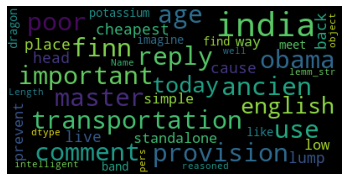

In [30]:
# Wordcloud for entire text in the dataset irrespective of classification as sincere or insincere

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.corpus.reader import WordListCorpusReader 

wordcloud = WordCloud(background_color='black',stopwords=stop_words, max_words=200, max_font_size=40, random_state=42).generate(str(df_adv['lemm_str']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("df_adv_lemm_str.png", dpi=300)

In [31]:
# Grouping and converting into dataframe based on the target value of 0 to be used for word cloud

df_adv_target_0 = pd.DataFrame(df_adv.groupby(['target']).get_group(0))
df_adv_target_0

,qid,nospaces,nostopwords,Tokenized_text,lemm_text,lemm_str,target
0,6f47b0f60633c2056455,how can reply to this comment india is poor it...,reply comment india poor fact understand unnec...,"[how, can, reply, to, this, comment, india, is...","[how, can, reply, to, this, comment, india, is...",how can reply to this comment india is poor it...,0
1,d49b3966070b27bf07fc,what did they use for transportation in ancien...,use transportation ancient india,"[what, did, they, use, for, transportation, in...","[what, did, they, use, for, transportation, in...",what did they use for transportation in ancien...,0
2,6d5faa49380557c8ca7b,what are the most important provisions of obam...,important provisions obamacare,"[what, are, the, most, important, provisions, ...","[what, are, the, most, important, provision, o...",what are the most important provision of obama...,0
3,cebea75faa47388edcf5,at what age do most finns master english today,age finns master english today,"[at, what, age, do, most, finns, master, engli...","[at, what, age, do, most, finn, master, englis...",at what age do most finn master english today,0
4,2a7b76a679cadb0a016e,what is cheapest place to live in india for on...,cheapest place live india one month best suits...,"[what, is, cheapest, place, to, live, in, indi...","[what, is, cheapest, place, to, live, in, indi...",what is cheapest place to live in india for on...,0
...,...,...,...,...,...,...,...
783667,af0e994fca341d876aee,do shiksha mitra deserve salary of rs per mont...,shiksha mitra deserve salary rs per month utta...,"[do, shiksha, mitra, deserve, salary, of, rs, ...","[do, shiksha, mitra, deserve, salary, of, r, p...",do shiksha mitra deserve salary of r per month...,0
783668,8462d2ead608fe1dcf9b,what causes lump on the back of your head,causes lump back head,"[what, causes, lump, on, the, back, of, your, ...","[what, cause, lump, on, the, back, of, your, h...",what cause lump on the back of your head,0
783669,12d225a4e28317c02151,what is standalone in simple way,standalone simple way,"[what, is, standalone, in, simple, way]","[what, is, standalone, in, simple, way]",what is standalone in simple way,0
783670,03edc045cadbb11558dd,how do you prevent having low potassium while ...,prevent low potassium pregnant,"[how, do, you, prevent, having, low, potassium...","[how, do, you, prevent, having, low, potassium...",how do you prevent having low potassium while ...,0


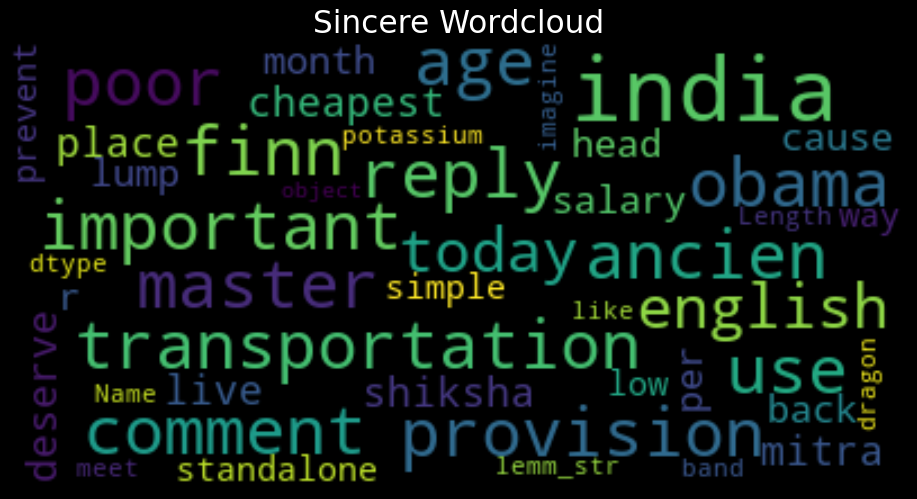

In [32]:
# Wordcloud for entire text in the dataset irrespective of classification as sincere or insincere

wordcloud = WordCloud(background_color='black',stopwords=stop_words, max_words=200, max_font_size=40, random_state=42).generate(str(df_adv_target_0['lemm_str']))

print(wordcloud)
fig = plt.figure(figsize=(10,7), dpi=90, facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("Sincere Wordcloud", fontsize=25,color='w')
plt.tight_layout(pad=0)
plt.show()
fig.savefig("df_adv_Sincere.png", dpi=300)

In [33]:
# Grouping and converting into dataframe based on the target value of 1 to be used for word cloud

df_adv_target_1 = pd.DataFrame(df_adv.groupby(['target']).get_group(1))
df_adv_target_1

,qid,nospaces,nostopwords,Tokenized_text,lemm_text,lemm_str,target
7,9863af25f17e29846aed,why do girls become escorts or sex workers,girls become escorts sex workers,"[why, do, girls, become, escorts, or, sex, wor...","[why, do, girl, become, escort, or, sex, worker]",why do girl become escort or sex worker,1
57,af9ecc698b3394b9cbd4,is it good to have sex with mother,good sex mother,"[is, it, good, to, have, sex, with, mother]","[is, it, good, to, have, sex, with, mother]",is it good to have sex with mother,1
67,3e922ddc3ffcd89af345,by persecuting britain first and other such gr...,persecuting britain first groups uk government...,"[by, persecuting, britain, first, and, other, ...","[by, persecuting, britain, first, and, other, ...",by persecuting britain first and other such gr...,1
122,afe196632a5ecc9b0921,how is it that guns are used to kill people ye...,guns used kill people year us whereas vehicles...,"[how, is, it, that, guns, are, used, to, kill,...","[how, is, it, that, gun, are, used, to, kill, ...",how is it that gun are used to kill people yea...,1
132,6eaf10e5c8eba21f713d,is it unethical of heterosexual women to perpe...,unethical heterosexual women perpetuate myth f...,"[is, it, unethical, of, heterosexual, women, t...","[is, it, unethical, of, heterosexual, woman, t...",is it unethical of heterosexual woman to perpe...,1
...,...,...,...,...,...,...,...
783596,ef882a9026bb1e84abf5,are fiitjeeians overconfident,fiitjeeians overconfident,"[are, fiitjeeians, overconfident]","[are, fiitjeeians, overconfident]",are fiitjeeians overconfident,1
783633,1a2c72159fc21c858fd8,why was barack hussein obama born with the nam...,barack hussein obama born name barry soetoro,"[why, was, barack, hussein, obama, born, with,...","[why, wa, barack, hussein, obama, born, with, ...",why wa barack hussein obama born with the name...,1
783643,42eb93986ed1f79dd071,why is trump not forcing white americans to ge...,trump forcing white americans get long make pe...,"[why, is, trump, not, forcing, white, american...","[why, is, trump, not, forcing, white, american...",why is trump not forcing white american to get...,1
783656,1f118d05b0e263c5ba35,did sikhs also kill hindus in punjab after the...,sikhs also kill hindus punjab riots,"[did, sikhs, also, kill, hindus, in, punjab, a...","[did, sikh, also, kill, hindu, in, punjab, aft...",did sikh also kill hindu in punjab after the riot,1


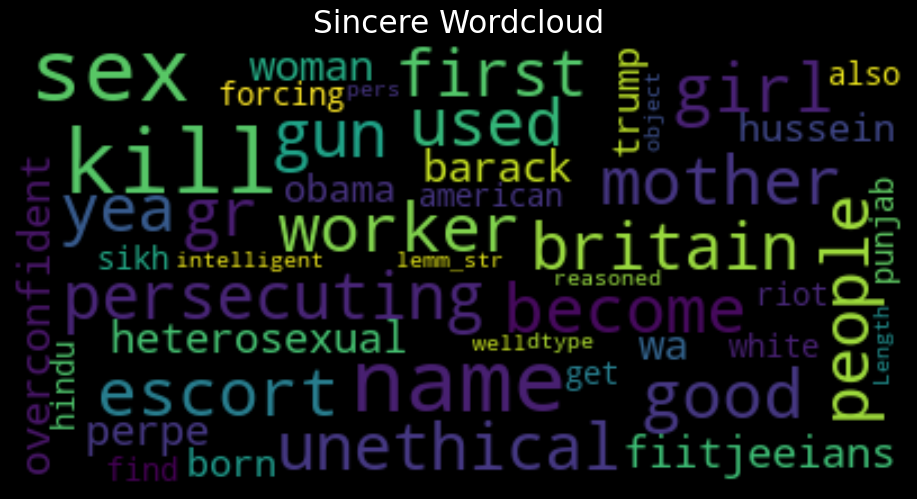

In [34]:
# Wordcloud for entire text in the dataset irrespective of classification as sincere or insincere

wordcloud = WordCloud(background_color='black',stopwords=stop_words, max_words=200, max_font_size=40, random_state=42).generate(str(df_adv_target_1['lemm_str']))

print(wordcloud)
fig = plt.figure(figsize=(10,7), dpi=90, facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("Sincere Wordcloud", fontsize=25,color='w')
plt.tight_layout(pad=0)
plt.show()
fig.savefig("df_trn_Insincere.png", dpi=300)

# ADVANCED PROCESSING WITHOUT STOPWORDS

In [35]:
def tokenize(txt):
    tokens = re.split('\W+', txt)
    return tokens


df_adv['nostopwords_Tokenized_text'] = df_adv['nostopwords'].apply(lambda x: tokenize(x.lower()))

df_adv.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,qid,nospaces,nostopwords,Tokenized_text,lemm_text,lemm_str,target,nostopwords_Tokenized_text
0,6f47b0f60633c2056455,how can reply to this comment india is poor it...,reply comment india poor fact understand unnec...,"[how, can, reply, to, this, comment, india, is...","[how, can, reply, to, this, comment, india, is...",how can reply to this comment india is poor it...,0,"[reply, comment, india, poor, fact, understand..."
1,d49b3966070b27bf07fc,what did they use for transportation in ancien...,use transportation ancient india,"[what, did, they, use, for, transportation, in...","[what, did, they, use, for, transportation, in...",what did they use for transportation in ancien...,0,"[use, transportation, ancient, india]"
2,6d5faa49380557c8ca7b,what are the most important provisions of obam...,important provisions obamacare,"[what, are, the, most, important, provisions, ...","[what, are, the, most, important, provision, o...",what are the most important provision of obama...,0,"[important, provisions, obamacare]"
3,cebea75faa47388edcf5,at what age do most finns master english today,age finns master english today,"[at, what, age, do, most, finns, master, engli...","[at, what, age, do, most, finn, master, englis...",at what age do most finn master english today,0,"[age, finns, master, english, today]"
4,2a7b76a679cadb0a016e,what is cheapest place to live in india for on...,cheapest place live india one month best suits...,"[what, is, cheapest, place, to, live, in, indi...","[what, is, cheapest, place, to, live, in, indi...",what is cheapest place to live in india for on...,0,"[cheapest, place, live, india, one, month, bes..."


In [36]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

wordnet=WordNetLemmatizer()
ps=PorterStemmer()

def lemmatization(tokens):
    text = [wordnet.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    return text

df_adv['nostopwords_lemm_text'] = df_adv['nostopwords_Tokenized_text'].apply(lambda x : lemmatization(x))
df_adv.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,qid,nospaces,nostopwords,Tokenized_text,lemm_text,lemm_str,target,nostopwords_Tokenized_text,nostopwords_lemm_text
0,6f47b0f60633c2056455,how can reply to this comment india is poor it...,reply comment india poor fact understand unnec...,"[how, can, reply, to, this, comment, india, is...","[how, can, reply, to, this, comment, india, is...",how can reply to this comment india is poor it...,0,"[reply, comment, india, poor, fact, understand...","[reply, comment, india, poor, fact, understand..."
1,d49b3966070b27bf07fc,what did they use for transportation in ancien...,use transportation ancient india,"[what, did, they, use, for, transportation, in...","[what, did, they, use, for, transportation, in...",what did they use for transportation in ancien...,0,"[use, transportation, ancient, india]","[use, transportation, ancient, india]"
2,6d5faa49380557c8ca7b,what are the most important provisions of obam...,important provisions obamacare,"[what, are, the, most, important, provisions, ...","[what, are, the, most, important, provision, o...",what are the most important provision of obama...,0,"[important, provisions, obamacare]","[important, provision, obamacare]"
3,cebea75faa47388edcf5,at what age do most finns master english today,age finns master english today,"[at, what, age, do, most, finns, master, engli...","[at, what, age, do, most, finn, master, englis...",at what age do most finn master english today,0,"[age, finns, master, english, today]","[age, finn, master, english, today]"
4,2a7b76a679cadb0a016e,what is cheapest place to live in india for on...,cheapest place live india one month best suits...,"[what, is, cheapest, place, to, live, in, indi...","[what, is, cheapest, place, to, live, in, indi...",what is cheapest place to live in india for on...,0,"[cheapest, place, live, india, one, month, bes...","[cheapest, place, live, india, one, month, bes..."


VECTORIZATION

In [37]:
#Converting List to strings

# Function to convert   
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 


df_adv['nostopwords_lemm_str'] = df_adv['nostopwords_lemm_text'].apply(lambda x: listToString(x))

df_adv.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,qid,nospaces,nostopwords,Tokenized_text,lemm_text,lemm_str,target,nostopwords_Tokenized_text,nostopwords_lemm_text,nostopwords_lemm_str
0,6f47b0f60633c2056455,how can reply to this comment india is poor it...,reply comment india poor fact understand unnec...,"[how, can, reply, to, this, comment, india, is...","[how, can, reply, to, this, comment, india, is...",how can reply to this comment india is poor it...,0,"[reply, comment, india, poor, fact, understand...","[reply, comment, india, poor, fact, understand...",reply comment india poor fact understand unnec...
1,d49b3966070b27bf07fc,what did they use for transportation in ancien...,use transportation ancient india,"[what, did, they, use, for, transportation, in...","[what, did, they, use, for, transportation, in...",what did they use for transportation in ancien...,0,"[use, transportation, ancient, india]","[use, transportation, ancient, india]",use transportation ancient india
2,6d5faa49380557c8ca7b,what are the most important provisions of obam...,important provisions obamacare,"[what, are, the, most, important, provisions, ...","[what, are, the, most, important, provision, o...",what are the most important provision of obama...,0,"[important, provisions, obamacare]","[important, provision, obamacare]",important provision obamacare
3,cebea75faa47388edcf5,at what age do most finns master english today,age finns master english today,"[at, what, age, do, most, finns, master, engli...","[at, what, age, do, most, finn, master, englis...",at what age do most finn master english today,0,"[age, finns, master, english, today]","[age, finn, master, english, today]",age finn master english today
4,2a7b76a679cadb0a016e,what is cheapest place to live in india for on...,cheapest place live india one month best suits...,"[what, is, cheapest, place, to, live, in, indi...","[what, is, cheapest, place, to, live, in, indi...",what is cheapest place to live in india for on...,0,"[cheapest, place, live, india, one, month, bes...","[cheapest, place, live, india, one, month, bes...",cheapest place live india one month best suit ...


In [38]:
df_adv.to_csv('QIQC_TextProcessed_TrainingSet.csv',index=False)

In [39]:
# df_adv.rename(columns = {'nospaces': 'text'}, inplace = True)